In [2]:
import matplotlib.pyplot as plt
import psycopg2
import pandas as pd
import numpy as np

In [3]:
conn = psycopg2.connect('dbname=cpdp user=blaine password=postgres')
cur = conn.cursor()

In [4]:
# Create Subset view
cur.execute('''
CREATE TEMP VIEW officer_subset AS
    SELECT o.id, o.first_name, o.last_name, o.birth_year, o.appointed_date,
          date_part('year', '2018-01-01'::DATE) - o.birth_year as estimated_age,
          ('2018-01-01'::DATE - o.appointed_date) / 365 as years_on_force,
          COUNT(a.id) as allegation_count
    FROM data_officer o
    LEFT JOIN data_officerallegation a on o.id = a.officer_id
    WHERE active = 'Yes'
        AND appointed_date BETWEEN '2000-01-01' AND '2007-12-31'
    GROUP BY o.id
    ORDER BY years_on_force DESC;
''')

In [5]:
# Create view with arrests by years on the force
cur.execute('''
CREATE VIEW officerarrest_years AS
    SELECT o.id as officer_id,
        officer_arrest.id as arrest_id,
        (officer_arrest.arrest_year - date_part('year', o.appointed_date)) as year_on_force
    FROM data_officerarrest officer_arrest
    INNER JOIN officer_subset o on officer_arrest.officer_id = o.id;
''')

In [6]:
# create view with allegations by years on the firce
cur.execute('''
CREATE VIEW officerallegation_years AS
    SELECT o.id as officer_id, 
        o.appointed_date, 
        allegation.incident_date, 
        allegation.id as allegation_id, 
        (date_part('year', allegation.incident_date) - date_part('year', o.appointed_date)) as year_on_force
    FROM officer_subset o
    INNER JOIN data_officerallegation officer_allegation ON officer_allegation.officer_id = o.id
    INNER JOIN data_allegation allegation ON allegation.id = officer_allegation.allegation_id;
''')

In [9]:
allegation_yof_df = pd.read_sql_query('''
SELECT year_on_force, COUNT(allegation_id) as count
    FROM officerallegation_years
    WHERE year_on_force >= 0
    GROUP BY year_on_force
    ORDER BY year_on_force ASC;
''', con=conn)

In [10]:
arrest_yof_df = pd.read_sql_query('''
SELECT year_on_force, COUNT(arrest_id) as count
    FROM officerarrest_years
    WHERE year_on_force >= 0
    GROUP BY year_on_force
    ORDER BY year_on_force ASC;
''', con=conn)

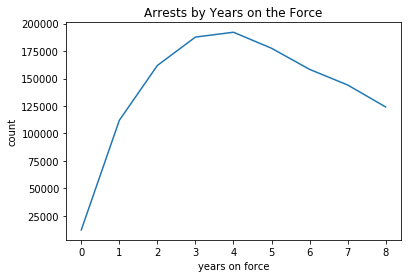

In [18]:
arrest_yrs = arrest_yof_df['year_on_force'][0:9]

arrest_count = arrest_yof_df['count'][0:9]

# no_cc = no_civil_case_df['avg_allegation_count']
# cc = civil_case_df['avg_allegation_count']

plt.plot(arrest_yrs, arrest_count, label="arrests")
# plt.plot(yrs, no_cc, label="without civil case")
# plt.plot(yrs, cc, label="with civil case")

plt.title('Arrests by Years on the Force')
plt.xlabel('years on force')
plt.ylabel('count')

plt.savefig('images/q3_arrests')

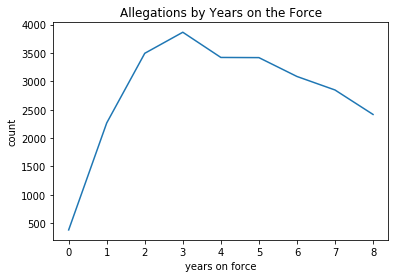

In [19]:
allegation_yrs = allegation_yof_df['year_on_force'][0:9]
allegation_count = allegation_yof_df['count'][0:9]
plt.plot(allegation_yrs, allegation_count, label="allegations")

plt.title('Allegations by Years on the Force')
plt.xlabel('years on force')
plt.ylabel('count')

plt.savefig('images/q3_allegations')

In [33]:
date_diff_df[10:21]

,date_diff,count
10,-5.0,744
11,-4.0,871
12,-3.0,1054
13,-2.0,1224
14,-1.0,1434
15,0.0,1163
16,1.0,807
17,2.0,630
18,3.0,523
19,4.0,411


In [34]:
(1434 - 744) / 1434

0.4811715481171548

In [35]:
(1434 - 306) / 1434

0.7866108786610879